# GNN with Chebyshev convolution

The GNN with Chebyshev convolution is our second GNN for semi-supervised node classification. As opposed to the four classical machine learning classifiers which serve as our baselines, it is capable of taking into account both the graph structure and the node features to predict the value of `segment` for a node.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import ipynb
from ipynb.fs.defs.dataset_creation import NodeClassificationDataset

import json
import os
import os.path as osp
import time

from sklearn.manifold import TSNE

import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import ChebConv
from torch_geometric.data import Data
from torch_geometric.data import Dataset, download_url
from torch_geometric.transforms import NormalizeFeatures, RandomNodeSplit

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

## Define helper functions

In [2]:
def reverse(tuples):
    """
    Reverse a 2-tuple.
    """
    new_tup = tuples[::-1]
    
    return new_tup

In [3]:
def mean(dict_values):
    """
    Get mean of dictionary values.
    """
    return np.mean(np.array(list(dict_values)))

In [4]:
def std(dict_values):
    """
    Get standard deviation of dictionary values.
    """
    return np.std(np.array(list(dict_values)))

In [5]:
def filter_best_hyperparameters(df, variable):
    """
    Filter the results data frame for the best hyperparameter combination(s).
    """
    return df[df[variable] == df[variable].max()]

In [6]:
def print_best_hyperparameters(df, variable):
    """
    Print best hyperparameter combination(s).
    """
    df_best = df[df[variable] == df[variable].max()]
    print('The best hyperparameter combination/s is/are:\n\t',
          '\n\t '.join([str(df_best['parameters'].iloc[i]) for i in range(len(df_best))]),
          '\nThe resulting mean best validation accuracy is:', df_best[variable].unique()[0])

In [7]:
def model_summary(model): 
    """
    Get a summary of the neural network/graph neural network.
    """
    model_params_list = list(model.named_parameters())
    print("----------------------------------------------------------------")
    line_new = "{:>20}  {:>25} {:>15}".format("Layer.Parameter", "Param Tensor Shape", "Param #")
    print(line_new)
    print("----------------------------------------------------------------")
    for elem in model_params_list:
        p_name = elem[0] 
        p_shape = list(elem[1].size())
        p_count = torch.tensor(elem[1].size()).prod().item()
        line_new = "{:>20}  {:>25} {:>15}".format(p_name, str(p_shape), str(p_count))
        print(line_new)
    print("----------------------------------------------------------------")
    total_params = sum([param.nelement() for param in model.parameters()])
    print("Total params:", total_params)
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Trainable params:", num_trainable_params)
    print("Non-trainable params:", total_params - num_trainable_params)

In [8]:
def visualize(h, color):
    """
    Visualize the learned embeddings after reducing them to two dimensions.
    """
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    scatter = plt.scatter(z[:, 0], z[:, 1], s=10, c=color, cmap="Set2")
    handles, _ = scatter.legend_elements(prop='colors')
    handles = [handles[i] for i in [2,3,1,0]]
    labels = ['S1', 'S2', 'S3', 'S4']
    return handles, labels

In [9]:
def plot_embeddings(df, filename, save):
    """
    Plot the two-dimensional embeddings in a 5 times 2 plot.
    """
    torch_geometric.seed_everything(12345)
    
    sns.set_style("whitegrid") 
    
    plt.figure(figsize=(8, 12))
   
    ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    out_mlp_1, out_mlp_2, out_mlp_3, out_mlp_4, out_mlp_5, out_mlp_6, out_mlp_7, out_mlp_8, out_mlp_9, out_mlp_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8, y_9, y_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    
    seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]
    axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]
    out_mlp = [out_mlp_1, out_mlp_2, out_mlp_3, out_mlp_4, out_mlp_5, out_mlp_6, out_mlp_7, out_mlp_8, out_mlp_9, out_mlp_10]
    y = [y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8, y_9, y_10]
    for i, seed in enumerate(seeds):
        out_mlp[i] = df['embeddings'][i] 
        y[i] = df['y'][i] 
        axes[i] = plt.subplot(5,2,i+1)
        handles, labels = visualize(out_mlp[i], color=y[i])
        axes[i].set_title(f"Run {i+1}: seed {seed}")

    for ax in axes:
        ax.set(xlabel='Dimension 1', ylabel='Dimension 2')
        
    plt.tight_layout() 
        
    legend = plt.legend(handles, labels, ncol=4, loc='upper center', bbox_to_anchor=(-0.1, -0.3), frameon=True, title='segment',
                        edgecolor='black')

    if save:
        plt.savefig(f"./plots/{filename}.svg", bbox_inches='tight')

In [10]:
def plot_losses_and_accuracies(plot_type, df, index, spacing, filename, save):
    """
    Create the data frames required for plotting the losses and accuracies.
    """
    sns.set_style("whitegrid")
    
    epoch_1, epoch_2, epoch_3, epoch_4, epoch_5, epoch_6, epoch_7, epoch_8, epoch_9, epoch_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    epochs = [epoch_1, epoch_2, epoch_3, epoch_4, epoch_5, epoch_6, epoch_7, epoch_8, epoch_9, epoch_10]
    
    if plot_type == 'loss':
        loss_df_1, loss_df_2, loss_df_3, loss_df_4, loss_df_5, loss_df_6, loss_df_7, loss_df_8, loss_df_9, loss_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
        loss_df = [loss_df_1, loss_df_2, loss_df_3, loss_df_4, loss_df_5, loss_df_6, loss_df_7, loss_df_8, loss_df_9, loss_df_10]
        print_list = ['loss'] * 10
    elif plot_type == 'acc':
        acc_df_1, acc_df_2, acc_df_3, acc_df_4, acc_df_5, acc_df_6, acc_df_7, acc_df_8, acc_df_9, acc_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        acc_df = [acc_df_1, acc_df_2, acc_df_3, acc_df_4, acc_df_5, acc_df_6, acc_df_7, acc_df_8, acc_df_9, acc_df_10]
        print_list = ['acc'] * 10
    elif plot_type == 'ap':
        ap_df_1, ap_df_2, ap_df_3, ap_df_4, ap_df_5, ap_df_6, ap_df_7, ap_df_8, ap_df_9, ap_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        ap_df = [ap_df_1, ap_df_2, ap_df_3, ap_df_4, ap_df_5, ap_df_6, ap_df_7, ap_df_8, ap_df_9, ap_df_10]
        print_list = ['ap'] * 10
    elif plot_type == 'auc':
        auc_df_1, auc_df_2, auc_df_3, auc_df_4, auc_df_5, auc_df_6, auc_df_7, auc_df_8, auc_df_9, auc_df_10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 
        auc_df = [auc_df_1, auc_df_2, auc_df_3, auc_df_4, auc_df_5, auc_df_6, auc_df_7, auc_df_8, auc_df_9, auc_df_10]
        print_list = ['auc'] * 10
    
    for i in range(len(epochs)):
        epochs[i] = [k for k in range(1, 1+len(df['train_losses'][index][f"{i+1}"]))]
    
        if plot_type == 'loss':
            loss_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_losses'][index][f"{i+1}"], \
                                               df['val_losses'][index][f"{i+1}"], df['test_losses'][index][f"{i+1}"])), \
                                      columns = ['epoch', 'train_loss', 'val_loss', 'test_loss'])
            loss_df[i] = pd.melt(loss_df[i], id_vars=['epoch'], value_vars=['train_loss', 'val_loss', 'test_loss'])
        elif plot_type == 'acc':
            acc_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_accs'][index][f"{i+1}"], \
                                              df['val_accs'][index][f"{i+1}"], df['test_accs'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_acc', 'val_acc', 'test_acc'])
            acc_df[i] = pd.melt(acc_df[i], id_vars=['epoch'], value_vars=['train_acc', 'val_acc', 'test_acc'])
        elif plot_type == 'ap':
            ap_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_aps'][index][f"{i+1}"], \
                                              df['val_aps'][index][f"{i+1}"], df['test_aps'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_ap', 'val_ap', 'test_ap'])
            ap_df[i] = pd.melt(ap_df[i], id_vars=['epoch'], value_vars=['train_ap', 'val_ap', 'test_ap'])
        elif plot_type == 'auc':
            auc_df[i] = pd.DataFrame(list(zip(epochs[i], df['train_aucs'][index][f"{i+1}"], \
                                              df['val_aucs'][index][f"{i+1}"], df['test_aucs'][index][f"{i+1}"])), \
                                     columns = ['epoch', 'train_auc', 'val_auc', 'test_auc'])
            auc_df[i] = pd.melt(auc_df[i], id_vars=['epoch'], value_vars=['train_auc', 'val_auc', 'test_auc'])
        
    seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]
    
    fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, fig9, fig10 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
    figs = [fig1, fig2, fig3, fig4, fig5, fig6, fig7, fig8, fig9, fig10]
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16,24))
    
    axes_list = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0], axes[2,1], axes[3,0], axes[3,1], axes[4,0], axes[4,1]]
    
    for j, seed in enumerate(seeds):
        if plot_type == 'loss':
            data = loss_df[j]
        elif plot_type == 'acc':
            data = acc_df[j]
        elif plot_type == 'ap':
            data = ap_df[j]
        elif plot_type == 'auc':
            data = auc_df[j]
        figs[j] = sns.lineplot(data=data, x="epoch", y="value", hue="variable", ax=axes_list[j]).set_title(f"Run {j + 1} with seed {seeds[j]}: {print_list[j]}/epoch", fontsize=16)
        axes_list[j].xaxis.set_major_locator(MultipleLocator(spacing))
    
    plt.tight_layout()
        
    if save:
        plt.savefig(f"./plots/{filename}.svg", bbox_inches='tight') 

## Hyperparameter tuning

We use the [PyTorch Geometric implementation](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.ChebConv) of a Chebyshev spectral graph convolution `ChebConv`. 

With GNNs using the Chebyshev spectral graph convolution, the main hyperparameters to tune are:
* `hidden_channels`: size of each hidden sample. It gives us the dimension of the embeddings in the hidden layer. 
* `K`: Chebyshev filter size. It gives us the highest order of the Chebyshev polynomials.
* `dropout_prob`: probability of an element to be zeroed.
* `learning_rate`: learning rate of the Adam optimizer.
* `weight_decay`: weight decay (L2 penalty).
* `patience`: number of epochs after which to stop the training process if no improvement in the validation loss has been observed in the meantime.

There are still other hyperparameters that can be tuned, e.g., the optimizer and the depth of the GNN using the Chebyshev spectral graph convolution. We do not train them and instead rely on standard choices, e.g., Adam as optimizer. As far as the depth is concerned, we rely on an architecture with only one hidden layer to avoid overfitting, given our relatively small number of 229 nodes. We now perform the hyperparameter tuning using loops.

In [11]:
# Create results folder
route0 = "./results"

if not os.path.exists(route0):
    os.mkdir(route0)

In [12]:
class ChebNet(torch.nn.Module):
    def __init__(self, hidden_channels, K, dropout_prob):
        super().__init__()
        self.conv1 = ChebConv(dataset.num_features, hidden_channels, K=K)
        self.conv2 = ChebConv(hidden_channels, dataset.num_classes, K=K)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=dropout_prob, training=self.training) # 0.1, 0.05 for dropout in GCN
        x = self.conv2(x, edge_index)
        return x
    
def train():
    model.train()
    optimizer.zero_grad()  
    out_train=model(data.x, data.edge_index)[data.train_mask]
    loss_train = criterion(out_train, data.y[data.train_mask])
    loss_train.backward()  
    optimizer.step()  
    model.eval()
    out_val = model(data.x, data.edge_index)[data.val_mask]
    loss_val = criterion(out_val, data.y[data.val_mask])
    out_test = model(data.x, data.edge_index)[data.test_mask]
    loss_test = criterion(out_test, data.y[data.test_mask])
    return loss_train, loss_val, loss_test, out_train, out_val, out_test


def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  
    train_correct = pred[data.train_mask] == data.y[data.train_mask]  
    val_correct = pred[data.val_mask] == data.y[data.val_mask]  
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  
    train_acc = int(train_correct.sum()) / int(data.train_mask.sum())  
    val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  
    return train_acc, val_acc, test_acc 

In [ ]:
start_time = time.time()

cheb_results = pd.DataFrame(columns = ['parameters', 'train_losses', 'val_losses', 'test_losses', 'train_accs', 'val_accs', 
                                       'test_accs', 'best_train_losses', 'best_val_losses', 'best_test_losses', 
                                       'best_train_accs', 'best_val_accs', 'best_test_accs', 'mean_best_train_loss', 
                                       'mean_best_val_loss', 'mean_best_test_loss', 'mean_best_train_acc', 'mean_best_val_acc', 
                                       'mean_best_test_acc', 'std_best_train_loss', 'std_best_val_loss', 'std_best_test_loss', 
                                       'std_best_train_acc', 'std_best_val_acc', 'std_best_test_acc'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

for hidden_channels in [8, 16, 32]:
    for K in [1, 2]: # 1, 2, 3, 4
        for dropout_prob in [0.1, 0.3, 0.5]: 
            for learning_rate in [0.001, 0.01, 0.1]:
                for weight_decay in [5e-1, 5e-2, 5e-3, 5e-4]: 
                    for patience in [5, 10]: #3, 5, 10

                        # Hyperparamter tuning
                        
                        print(f'====================================================================================================\nParameter combination: {{hidden_channels: {hidden_channels}, K: {K}, dropout_prob: {dropout_prob}, learning_rate: {learning_rate}, weight_decay: {weight_decay}, patience: {patience}}}\n====================================================================================================')

                        parameter_dict = dict({'hidden_channels': hidden_channels, 'K': K, 'dropout_prob': dropout_prob, 'learning_rate': learning_rate, 'weight_decay': weight_decay, 'patience': patience})

                        loss_dict = dict() 
                        val_loss_dict = dict() 
                        test_loss_dict = dict() 
                        train_acc_dict = dict() 
                        val_acc_dict = dict() 
                        test_acc_dict = dict() 

                        best_train_loss_dict = dict()
                        best_val_loss_dict = dict()
                        best_test_loss_dict = dict()
                        best_train_acc_dict = dict()
                        best_val_acc_dict = dict()
                        best_test_acc_dict = dict()

                        for i, seed in enumerate(seeds): 

                            torch_geometric.seed_everything(seed) 

                            dataset = NodeClassificationDataset(root='data/', transform=RandomNodeSplit(split="random", num_train_per_class = 10, num_val = 60, num_test = 129))
                            data = dataset[0]
                            
                            model = ChebNet(hidden_channels = hidden_channels, K = K, dropout_prob = dropout_prob)

                            criterion = torch.nn.CrossEntropyLoss()  
                            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  

                            loss_list = []
                            val_loss_list = []
                            test_loss_list = []
                            train_acc_list = []
                            val_acc_list = []
                            test_acc_list = []

                            last_loss = 100
                            patience = patience 
                            trigger_times = 0

                            print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

                            for epoch in range(1, 101):
                                loss, val_loss, test_loss, out_train, out_val, out_test = train() 
                                train_acc, val_acc, test_acc = test() 
                                loss_list += [loss.item()]
                                val_loss_list += [val_loss.item()]
                                test_loss_list += [test_loss.item()]
                                train_acc_list += [train_acc]
                                val_acc_list += [val_acc]
                                test_acc_list += [test_acc]

                                current_val_loss = val_loss

                                print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, train acc: {train_acc:.4f}, val acc: {val_acc:.4f}, test acc: {test_acc:.4f}')
                                
                                if current_val_loss <= last_loss:
                                    current_best_train_loss = loss.item()
                                    current_best_val_loss = current_val_loss.item()
                                    current_best_test_loss = test_loss.item()
                                    current_best_train_acc = train_acc
                                    current_best_val_acc = val_acc
                                    current_best_test_acc = test_acc

                                    trigger_times = 0
                                    print('Trigger times: 0')

                                    last_loss = current_val_loss

                                else: 
                                    trigger_times += 1
                                    print('Trigger times:', trigger_times)

                                    if trigger_times >= patience:
                                        print('Early stopping!')
                                        break

                            loss_dict.update({f"{i+1}": loss_list}) 
                            val_loss_dict.update({f"{i+1}": val_loss_list}) 
                            test_loss_dict.update({f"{i+1}": test_loss_list}) 
                            train_acc_dict.update({f"{i+1}": train_acc_list}) 
                            val_acc_dict.update({f"{i+1}": val_acc_list}) 
                            test_acc_dict.update({f"{i+1}": test_acc_list}) 

                            best_train_loss_dict.update({f"{i+1}": current_best_train_loss}) 
                            best_val_loss_dict.update({f"{i+1}": current_best_val_loss}) 
                            best_test_loss_dict.update({f"{i+1}": current_best_test_loss}) 
                            best_train_acc_dict.update({f"{i+1}": current_best_train_acc})
                            best_val_acc_dict.update({f"{i+1}": current_best_val_acc}) 
                            best_test_acc_dict.update({f"{i+1}": current_best_test_acc}) 

                            print(current_best_val_loss)

                        data_concat = [{'parameters': parameter_dict, 'train_losses': loss_dict, 'val_losses': val_loss_dict, 
                                        'test_losses': test_loss_dict, 'train_accs': train_acc_dict, 'val_accs': val_acc_dict, 
                                        'test_accs': test_acc_dict, 'best_train_losses': best_train_loss_dict, 
                                        'best_val_losses': best_val_loss_dict, 'best_test_losses': best_test_loss_dict, 
                                        'best_train_accs': best_train_acc_dict, 'best_val_accs': best_val_acc_dict, 
                                        'best_test_accs': best_test_acc_dict, 
                                        'mean_best_train_loss': mean(best_train_loss_dict.values()), 
                                        'mean_best_val_loss': mean(best_val_loss_dict.values()), 
                                        'mean_best_test_loss': mean(best_test_loss_dict.values()), 
                                        'mean_best_train_acc': mean(best_train_acc_dict.values()), 
                                        'mean_best_val_acc': mean(best_val_acc_dict.values()), 
                                        'mean_best_test_acc': mean(best_test_acc_dict.values()),
                                        'std_best_train_loss': std(best_train_loss_dict.values()), 
                                        'std_best_val_loss': std(best_val_loss_dict.values()), 
                                        'std_best_test_loss': std(best_test_loss_dict.values()), 
                                        'std_best_train_acc': std(best_train_acc_dict.values()), 
                                        'std_best_val_acc': std(best_val_acc_dict.values()), 
                                        'std_best_test_acc': std(best_test_acc_dict.values())}]
                        df_concat = pd.DataFrame(data_concat)
                        cheb_results = pd.concat([cheb_results, df_concat], ignore_index=True)
                    
print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to cheb_results.pkl")
cheb_results.to_pickle(f"{route0}/cheb_results.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

In [13]:
# Look at results
cheb_results = pd.read_pickle(f"{route0}/cheb_results.pkl") 
cheb_results

,parameters,train_losses,val_losses,test_losses,train_accs,val_accs,test_accs,best_train_losses,best_val_losses,best_test_losses,...,mean_best_test_loss,mean_best_train_acc,mean_best_val_acc,mean_best_test_acc,std_best_train_loss,std_best_val_loss,std_best_test_loss,std_best_train_acc,std_best_val_acc,std_best_test_acc
0,"{'hidden_channels': 8, 'K': 1, 'dropout_prob':...","{'1': [1.477355718612671, 1.4780652523040771, ...","{'1': [1.6485041379928589, 1.6434788703918457,...","{'1': [1.5695462226867676, 1.5652261972427368,...","{'1': [0.025, 0.025, 0.025, 0.025, 0.025, 0.02...","{'1': [0.08333333333333333, 0.0833333333333333...","{'1': [0.05426356589147287, 0.0542635658914728...","{'1': 1.3822075128555298, '2': 1.3542320728302...","{'1': 1.420957088470459, '2': 1.21587049961090...","{'1': 1.4030847549438477, '2': 1.2760003805160...",...,1.306823,0.3925,0.385000,0.385271,0.069276,0.061320,0.054774,0.146650,0.135082,0.147656
1,"{'hidden_channels': 8, 'K': 1, 'dropout_prob':...","{'1': [1.477355718612671, 1.4780652523040771, ...","{'1': [1.6485041379928589, 1.6434788703918457,...","{'1': [1.5695462226867676, 1.5652261972427368,...","{'1': [0.025, 0.025, 0.025, 0.025, 0.025, 0.02...","{'1': [0.08333333333333333, 0.0833333333333333...","{'1': [0.05426356589147287, 0.0542635658914728...","{'1': 1.3822075128555298, '2': 1.3542320728302...","{'1': 1.420957088470459, '2': 1.21587049961090...","{'1': 1.4030847549438477, '2': 1.2760003805160...",...,1.306823,0.3925,0.385000,0.385271,0.069276,0.061320,0.054774,0.146650,0.135082,0.147656
2,"{'hidden_channels': 8, 'K': 1, 'dropout_prob':...","{'1': [1.477355718612671, 1.4764864444732666, ...","{'1': [1.647957444190979, 1.642066478729248, 1...","{'1': [1.568598985671997, 1.5630897283554077, ...","{'1': [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...","{'1': [0.08333333333333333, 0.0833333333333333...","{'1': [0.05426356589147287, 0.0542635658914728...","{'1': 1.2248972654342651, '2': 1.0360236167907...","{'1': 1.3880091905593872, '2': 1.0958536863327...","{'1': 1.3418562412261963, '2': 1.1792643070220...",...,1.195080,0.6550,0.520000,0.524031,0.186707,0.120477,0.107445,0.220454,0.212368,0.188173
3,"{'hidden_channels': 8, 'K': 1, 'dropout_prob':...","{'1': [1.477355718612671, 1.4764864444732666, ...","{'1': [1.647957444190979, 1.642066478729248, 1...","{'1': [1.568598985671997, 1.5630897283554077, ...","{'1': [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...","{'1': [0.08333333333333333, 0.0833333333333333...","{'1': [0.05426356589147287, 0.0542635658914728...","{'1': 1.2248972654342651, '2': 1.0360236167907...","{'1': 1.3880091905593872, '2': 1.0958536863327...","{'1': 1.3418562412261963, '2': 1.1792643070220...",...,1.195080,0.6550,0.520000,0.524031,0.186707,0.120477,0.107445,0.220454,0.212368,0.188173
4,"{'hidden_channels': 8, 'K': 1, 'dropout_prob':...","{'1': [1.477355718612671, 1.4758508205413818, ...","{'1': [1.6474933624267578, 1.641323447227478, ...","{'1': [1.5679560899734497, 1.5619661808013916,...","{'1': [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0...","{'1': [0.08333333333333333, 0.0833333333333333...","{'1': [0.05426356589147287, 0.0542635658914728...","{'1': 1.1236215829849243, '2': 0.9650335311889...","{'1': 1.3940699100494385, '2': 1.0715130567550...","{'1': 1.326943278312683, '2': 1.17370152473449...",...,1.143159,0.7400,0.520000,0.558915,0.162344,0.126060,0.121502,0.210119,0.180555,0.160278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,"{'hidden_channels': 32, 'K': 2, 'dropout_prob'...","{'1': [1.6750705242156982, 2.636404514312744, ...","{'1': [3.0285651683807373, 3.9080073833465576,...","{'1': [2.508056402206421, 3.867542028427124, 1...","{'1': [0.6, 0.25, 0.25, 0.475, 0.475, 0.5, 0.6...","{'1': [0.2833333333333333, 0.01666666666666666...","{'1': [0.32558139534883723, 0.0775193798449612...","{'1': 0.4252026677131653, '2': 0.5487164258956...","{'1': 0.4685809910297394, '2': 0.5381721258163...","{'1': 0.5248293876647949, '2': 0.6224669218063..

## Best hyperparameter combination

In [14]:
filter_best_hyperparameters(cheb_results, 'mean_best_val_acc')

,parameters,train_losses,val_losses,test_losses,train_accs,val_accs,test_accs,best_train_losses,best_val_losses,best_test_losses,...,mean_best_test_loss,mean_best_train_acc,mean_best_val_acc,mean_best_test_acc,std_best_train_loss,std_best_val_loss,std_best_test_loss,std_best_train_acc,std_best_val_acc,std_best_test_acc
307,"{'hidden_channels': 32, 'K': 1, 'dropout_prob'...","{'1': [1.6581951379776, 1.2679804563522339, 1....","{'1': [1.5100804567337036, 1.0633690357208252,...","{'1': [1.511871576309204, 1.0780761241912842, ...","{'1': [0.35, 0.35, 0.825, 0.725, 0.9, 0.975, 0...","{'1': [0.21666666666666667, 0.4666666666666667...","{'1': [0.20930232558139536, 0.4341085271317829...","{'1': 0.16421149671077728, '2': 0.159555196762...","{'1': 0.38144782185554504, '2': 0.383673012256...","{'1': 0.372795045375824, '2': 0.42383068799972...",...,0.405902,0.980,0.858333,0.875969,0.080959,0.078450,0.033460,0.015000,0.034359,0.018344
355,"{'hidden_channels': 32, 'K': 1, 'dropout_prob'...","{'1': [1.6901439428329468, 1.2417066097259521,...","{'1': [1.4015368223190308, 1.2000010013580322,...","{'1': [1.4202449321746826, 1.197117805480957, ...","{'1': [0.35, 0.6, 0.825, 0.875, 0.925, 0.95, 0...","{'1': [0.18333333333333332, 0.5333333333333333...","{'1': [0.24031007751937986, 0.5426356589147286...","{'1': 0.3091723918914795, '2': 0.3830080330371...","{'1': 0.42788761854171753, '2': 0.404389739036...","{'1': 0.4465809762477875, '2': 0.4706597328186...",...,0.473123,0.955,0.858333,0.873643,0.101567,0.083425,0.043158,0.031225,0.050139,0.026414


In [15]:
print_best_hyperparameters(cheb_results, 'mean_best_val_acc')

The best hyperparameter combination/s is/are:
	 {'hidden_channels': 32, 'K': 1, 'dropout_prob': 0.1, 'learning_rate': 0.1, 'weight_decay': 0.05, 'patience': 10}
	 {'hidden_channels': 32, 'K': 1, 'dropout_prob': 0.5, 'learning_rate': 0.1, 'weight_decay': 0.05, 'patience': 10} 
The resulting validation accuracy is: 0.8583333333333334


We see that there are two hyperparameter combinations that lead to the highest mean best validation accuracy of 0.8583. These hyperparameter combinations differ only in their respective value of `dropout_prob`, where one has a value of 0.1 and the other has a value of 0.5. Apart from their equal values for the mean best validation accuracy, they display different values for the mean best training accuracy and the mean best test accuracy as well as for the standard deviations of the best training, validation and test accuracies. We see that the hyperparameter combination where `dropout_prob` equals 0.1 has higher mean best train and test accuracies and lower standard deviations of best train, validation and test accuracies and is therefore the best hyperparameter combination.

So, our best hyperparameter combination is given by:

* hidden_channels = 32
* K = 1
* dropout_prob = 0.1
* learning_rate = 0.1
* weight_decay = 0.05
* patience = 10

It gives a mean best training accuracy of 0.9800, where the mean best validation accuracy of 0.8583 and the mean best test accuracy of 0.8760 are a little lower. The standard deviation of the best training accuracies of 0.0150 is very low, where the standard deviations of the best validation accuracies and the best test accuracies are a bit higher, with values of 0.0344 and 0.0183, respectively.

## Visualizations

In [16]:
# Repeat 10 runs of best model

start_time = time.time()

cheb_embeddings = pd.DataFrame(columns=['run', 'embeddings', 'y'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

# Best hyperparameters
hidden_channels = 32
K = 1
dropout_prob = 0.1
learning_rate = 0.1
weight_decay = 5e-2
patience = 10
                    
print(f'====================================================================================================\nParameter combination: {{hidden_channels: {hidden_channels}, K: {K}, dropout_prob: {dropout_prob}, learning_rate: {learning_rate}, weight_decay: {weight_decay}, patience: {patience}}}\n====================================================================================================')

parameter_dict = dict({'hidden_channels': hidden_channels, 'K': K, 'dropout_prob': dropout_prob, 'learning_rate': learning_rate, 'weight_decay': weight_decay, 'patience': patience})

for i, seed in enumerate(seeds): 

    torch_geometric.seed_everything(seed) 

    dataset = NodeClassificationDataset(root='data/', transform=RandomNodeSplit(split="random", num_train_per_class = 10, num_val = 60, num_test = 129))
    data = dataset[0]
    
    model = ChebNet(hidden_channels=hidden_channels, K=K, dropout_prob=dropout_prob)

    criterion = torch.nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) 

    last_loss = 100
    patience = patience 
    trigger_times = 0

    print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')

    for epoch in range(1, 101):
        loss, val_loss, test_loss, out_train, out_val, out_test = train() 
        train_acc, val_acc, test_acc = test() 

        current_val_loss = val_loss

        print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}, train acc: {train_acc:.4f}, val acc: {val_acc:.4f}, test acc: {test_acc:.4f}')

        if current_val_loss <= last_loss:
            current_best_train_loss = loss.item()
            current_best_val_loss = current_val_loss.item()
            current_best_test_loss = test_loss.item()
            current_best_out_train = out_train
            current_best_out_val = out_val
            current_best_out_test = out_test
            current_best_train_acc = train_acc
            current_best_val_acc = val_acc
            current_best_test_acc = test_acc
            
            trigger_times = 0
            print('Trigger times: 0')
            
            last_loss = current_val_loss

        else: 
            trigger_times += 1
            print('Trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!')
                break

    print(current_best_val_loss)
    
    embed = [{'run': i+1, 'embeddings': torch.cat((current_best_out_train, current_best_out_val, current_best_out_test), 0), 'y': data.y}]
    embed = pd.DataFrame(embed)
    cheb_embeddings = pd.concat([cheb_embeddings, embed], ignore_index=True)
                    
print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to cheb_embeddings.pkl")
cheb_embeddings.to_pickle(f"{route0}/cheb_embeddings.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

Parameter combination: {hidden_channels: 32, K: 1, dropout_prob: 0.1, learning_rate: 0.1, weight_decay: 0.05, patience: 10}
Run 1 with seed 12345:
Epoch: 001, Train Loss: 1.6582, Val Loss: 1.5101, Test Loss: 1.5119, train acc: 0.3500, val acc: 0.2167, test acc: 0.2093

Processing...
Done!



Trigger times: 0
Epoch: 002, Train Loss: 1.2680, Val Loss: 1.0634, Test Loss: 1.0781, train acc: 0.3500, val acc: 0.4667, test acc: 0.4341
Trigger times: 0
Epoch: 003, Train Loss: 1.0416, Val Loss: 1.0912, Test Loss: 1.0566, train acc: 0.8250, val acc: 0.6000, test acc: 0.6202
Trigger times: 1
Epoch: 004, Train Loss: 0.8240, Val Loss: 1.0635, Test Loss: 1.0272, train acc: 0.7250, val acc: 0.5167, test acc: 0.5659
Trigger times: 2
Epoch: 005, Train Loss: 0.6676, Val Loss: 0.8247, Test Loss: 0.8079, train acc: 0.9000, val acc: 0.6833, test acc: 0.7287
Trigger times: 0
Epoch: 006, Train Loss: 0.5015, Val Loss: 0.5643, Test Loss: 0.5682, train acc: 0.9750, val acc: 0.8167, test acc: 0.8372
Trigger times: 0
Epoch: 007, Train Loss: 0.3830, Val Loss: 0.4351, Test Loss: 0.4385, train acc: 0.9750, val acc: 0.8333, test acc: 0.8837
Trigger times: 0
Epoch: 008, Train Loss: 0.2901, Val Loss: 0.4169, Test Loss: 0.3898, train acc: 0.9750, val acc: 0.8333, test acc: 0.8915
Trigger times: 0
Epoch: 00

Processing...
Done!


Run 2 with seed 23456:
Epoch: 001, Train Loss: 1.5465, Val Loss: 1.5326, Test Loss: 1.6074, train acc: 0.2750, val acc: 0.1000, test acc: 0.0698
Trigger times: 0
Epoch: 002, Train Loss: 1.2293, Val Loss: 0.9136, Test Loss: 0.8925, train acc: 0.9000, val acc: 0.8167, test acc: 0.8295
Trigger times: 0
Epoch: 003, Train Loss: 0.7550, Val Loss: 0.8889, Test Loss: 0.7015, train acc: 0.7750, val acc: 0.6167, test acc: 0.8062
Trigger times: 0
Epoch: 004, Train Loss: 0.5844, Val Loss: 0.6209, Test Loss: 0.5823, train acc: 0.9750, val acc: 0.8167, test acc: 0.8527
Trigger times: 0
Epoch: 005, Train Loss: 0.4343, Val Loss: 0.6398, Test Loss: 0.6060, train acc: 0.9750, val acc: 0.7667, test acc: 0.8062
Trigger times: 1
Epoch: 006, Train Loss: 0.2458, Val Loss: 0.5973, Test Loss: 0.5671, train acc: 0.9750, val acc: 0.8000, test acc: 0.8217
Trigger times: 0
Epoch: 007, Train Loss: 0.1971, Val Loss: 0.4980, Test Loss: 0.4991, train acc: 1.0000, val acc: 0.8500, test acc: 0.8450
Trigger times: 0
Epoc

Processing...
Done!


Trigger times: 0
Epoch: 003, Train Loss: 0.9107, Val Loss: 1.0006, Test Loss: 0.8619, train acc: 0.9750, val acc: 0.6167, test acc: 0.7674
Trigger times: 0
Epoch: 004, Train Loss: 0.4953, Val Loss: 0.9721, Test Loss: 0.7692, train acc: 0.9250, val acc: 0.6167, test acc: 0.7442
Trigger times: 0
Epoch: 005, Train Loss: 0.3900, Val Loss: 0.7612, Test Loss: 0.5565, train acc: 1.0000, val acc: 0.7167, test acc: 0.8372
Trigger times: 0
Epoch: 006, Train Loss: 0.2308, Val Loss: 0.5552, Test Loss: 0.4304, train acc: 0.9250, val acc: 0.8833, test acc: 0.9225
Trigger times: 0
Epoch: 007, Train Loss: 0.2337, Val Loss: 0.6615, Test Loss: 0.4389, train acc: 0.9750, val acc: 0.8167, test acc: 0.8915
Trigger times: 1
Epoch: 008, Train Loss: 0.1656, Val Loss: 0.7743, Test Loss: 0.4970, train acc: 0.9500, val acc: 0.7167, test acc: 0.8527
Trigger times: 2
Epoch: 009, Train Loss: 0.2269, Val Loss: 0.6491, Test Loss: 0.4475, train acc: 0.9750, val acc: 0.8000, test acc: 0.8915
Trigger times: 3
Epoch: 010

Processing...
Done!



Trigger times: 1
Epoch: 005, Train Loss: 0.3519, Val Loss: 0.8171, Test Loss: 0.6019, train acc: 0.9750, val acc: 0.6833, test acc: 0.7829
Trigger times: 2
Epoch: 006, Train Loss: 0.3520, Val Loss: 0.7347, Test Loss: 0.4877, train acc: 0.9750, val acc: 0.7667, test acc: 0.8682
Trigger times: 3
Epoch: 007, Train Loss: 0.2940, Val Loss: 0.6723, Test Loss: 0.4969, train acc: 0.9500, val acc: 0.7833, test acc: 0.8450
Trigger times: 4
Epoch: 008, Train Loss: 0.2797, Val Loss: 0.6436, Test Loss: 0.5366, train acc: 0.9250, val acc: 0.7833, test acc: 0.8140
Trigger times: 5
Epoch: 009, Train Loss: 0.2903, Val Loss: 0.5833, Test Loss: 0.4553, train acc: 0.9500, val acc: 0.8000, test acc: 0.8760
Trigger times: 0
Epoch: 010, Train Loss: 0.2998, Val Loss: 0.6130, Test Loss: 0.4597, train acc: 0.9750, val acc: 0.7667, test acc: 0.8837
Trigger times: 1
Epoch: 011, Train Loss: 0.2848, Val Loss: 0.7239, Test Loss: 0.5289, train acc: 0.9750, val acc: 0.7000, test acc: 0.8062
Trigger times: 2
Epoch: 01

Processing...
Done!



Trigger times: 0
Epoch: 006, Train Loss: 0.3889, Val Loss: 0.4666, Test Loss: 0.4455, train acc: 0.9750, val acc: 0.8167, test acc: 0.8760
Trigger times: 0
Epoch: 007, Train Loss: 0.3417, Val Loss: 0.5334, Test Loss: 0.4850, train acc: 0.9750, val acc: 0.8333, test acc: 0.8837
Trigger times: 1
Epoch: 008, Train Loss: 0.2039, Val Loss: 0.5492, Test Loss: 0.4575, train acc: 0.9500, val acc: 0.8000, test acc: 0.8760
Trigger times: 2
Epoch: 009, Train Loss: 0.2432, Val Loss: 0.5368, Test Loss: 0.4358, train acc: 0.9750, val acc: 0.7667, test acc: 0.8605
Trigger times: 3
Epoch: 010, Train Loss: 0.2488, Val Loss: 0.5029, Test Loss: 0.4371, train acc: 0.9750, val acc: 0.8167, test acc: 0.8682
Trigger times: 4
Epoch: 011, Train Loss: 0.1609, Val Loss: 0.5454, Test Loss: 0.5158, train acc: 1.0000, val acc: 0.8333, test acc: 0.8527
Trigger times: 5
Epoch: 012, Train Loss: 0.2488, Val Loss: 0.5849, Test Loss: 0.5317, train acc: 0.9750, val acc: 0.8000, test acc: 0.8450
Trigger times: 6
Epoch: 01

Processing...
Done!



Epoch: 001, Train Loss: 1.4364, Val Loss: 1.0343, Test Loss: 1.0644, train acc: 0.7750, val acc: 0.6500, test acc: 0.5426
Trigger times: 0
Epoch: 002, Train Loss: 0.9098, Val Loss: 0.7651, Test Loss: 0.8190, train acc: 0.9250, val acc: 0.7833, test acc: 0.7054
Trigger times: 0
Epoch: 003, Train Loss: 0.6086, Val Loss: 0.7301, Test Loss: 0.7366, train acc: 0.8750, val acc: 0.7000, test acc: 0.7752
Trigger times: 0
Epoch: 004, Train Loss: 0.4626, Val Loss: 0.4521, Test Loss: 0.4448, train acc: 0.9750, val acc: 0.8500, test acc: 0.8682
Trigger times: 0
Epoch: 005, Train Loss: 0.3756, Val Loss: 0.3769, Test Loss: 0.3876, train acc: 1.0000, val acc: 0.8833, test acc: 0.8760
Trigger times: 0
Epoch: 006, Train Loss: 0.2056, Val Loss: 0.4399, Test Loss: 0.4372, train acc: 1.0000, val acc: 0.8667, test acc: 0.8837
Trigger times: 1
Epoch: 007, Train Loss: 0.2413, Val Loss: 0.5285, Test Loss: 0.4705, train acc: 1.0000, val acc: 0.8500, test acc: 0.8915
Trigger times: 2
Epoch: 008, Train Loss: 0.

Processing...
Done!



Trigger times: 1
Epoch: 005, Train Loss: 0.4466, Val Loss: 0.6723, Test Loss: 0.5377, train acc: 0.9500, val acc: 0.8000, test acc: 0.8605
Trigger times: 0
Epoch: 006, Train Loss: 0.3136, Val Loss: 0.5374, Test Loss: 0.3935, train acc: 0.9500, val acc: 0.8167, test acc: 0.8760
Trigger times: 0
Epoch: 007, Train Loss: 0.2468, Val Loss: 0.5238, Test Loss: 0.3419, train acc: 0.9500, val acc: 0.8333, test acc: 0.8837
Trigger times: 0
Epoch: 008, Train Loss: 0.1841, Val Loss: 0.5669, Test Loss: 0.3685, train acc: 0.9500, val acc: 0.8167, test acc: 0.8837
Trigger times: 1
Epoch: 009, Train Loss: 0.1972, Val Loss: 0.5216, Test Loss: 0.3548, train acc: 1.0000, val acc: 0.8333, test acc: 0.8837
Trigger times: 0
Epoch: 010, Train Loss: 0.1683, Val Loss: 0.4916, Test Loss: 0.3516, train acc: 0.9750, val acc: 0.8333, test acc: 0.8837
Trigger times: 0
Epoch: 011, Train Loss: 0.2294, Val Loss: 0.5277, Test Loss: 0.3856, train acc: 0.9500, val acc: 0.8333, test acc: 0.8915
Trigger times: 1
Epoch: 01

Processing...
Done!



Trigger times: 0
Epoch: 007, Train Loss: 0.2184, Val Loss: 0.3935, Test Loss: 0.4104, train acc: 0.9750, val acc: 0.8833, test acc: 0.8760
Trigger times: 0
Epoch: 008, Train Loss: 0.2114, Val Loss: 0.4150, Test Loss: 0.3719, train acc: 0.9750, val acc: 0.8500, test acc: 0.8760
Trigger times: 1
Epoch: 009, Train Loss: 0.2115, Val Loss: 0.5479, Test Loss: 0.4630, train acc: 0.9500, val acc: 0.8333, test acc: 0.8682
Trigger times: 2
Epoch: 010, Train Loss: 0.1736, Val Loss: 0.5709, Test Loss: 0.4913, train acc: 0.9500, val acc: 0.8333, test acc: 0.8682
Trigger times: 3
Epoch: 011, Train Loss: 0.1995, Val Loss: 0.5015, Test Loss: 0.4457, train acc: 0.9750, val acc: 0.8500, test acc: 0.8605
Trigger times: 4
Epoch: 012, Train Loss: 0.2098, Val Loss: 0.4856, Test Loss: 0.4527, train acc: 1.0000, val acc: 0.8333, test acc: 0.8605
Trigger times: 5
Epoch: 013, Train Loss: 0.2830, Val Loss: 0.5105, Test Loss: 0.4667, train acc: 1.0000, val acc: 0.8333, test acc: 0.8682
Trigger times: 6
Epoch: 01

Processing...
Done!


Trigger times: 0
Epoch: 008, Train Loss: 0.2723, Val Loss: 0.3709, Test Loss: 0.4647, train acc: 1.0000, val acc: 0.8833, test acc: 0.8372
Trigger times: 0
Epoch: 009, Train Loss: 0.2274, Val Loss: 0.3708, Test Loss: 0.4417, train acc: 0.9750, val acc: 0.8667, test acc: 0.8527
Trigger times: 0
Epoch: 010, Train Loss: 0.2947, Val Loss: 0.3820, Test Loss: 0.5107, train acc: 0.9750, val acc: 0.9167, test acc: 0.8140
Trigger times: 1
Epoch: 011, Train Loss: 0.2321, Val Loss: 0.4071, Test Loss: 0.5934, train acc: 0.9500, val acc: 0.8500, test acc: 0.8140
Trigger times: 2
Epoch: 012, Train Loss: 0.2151, Val Loss: 0.4095, Test Loss: 0.5872, train acc: 0.9750, val acc: 0.8833, test acc: 0.8140
Trigger times: 3
Epoch: 013, Train Loss: 0.2501, Val Loss: 0.4361, Test Loss: 0.5712, train acc: 0.9750, val acc: 0.8667, test acc: 0.7984
Trigger times: 4
Epoch: 014, Train Loss: 0.2448, Val Loss: 0.4627, Test Loss: 0.6107, train acc: 0.9750, val acc: 0.8833, test acc: 0.7984
Trigger times: 5
Epoch: 015

Processing...
Done!


Run 10 with seed 98765:
Epoch: 001, Train Loss: 1.4693, Val Loss: 1.6629, Test Loss: 1.6300, train acc: 0.3750, val acc: 0.1500, test acc: 0.1550
Trigger times: 0
Epoch: 002, Train Loss: 1.2906, Val Loss: 0.9416, Test Loss: 0.9439, train acc: 0.8250, val acc: 0.7000, test acc: 0.7519
Trigger times: 0
Epoch: 003, Train Loss: 0.9334, Val Loss: 0.7940, Test Loss: 0.8760, train acc: 0.7000, val acc: 0.7333, test acc: 0.6899
Trigger times: 0
Epoch: 004, Train Loss: 0.8286, Val Loss: 0.7034, Test Loss: 0.7425, train acc: 0.9500, val acc: 0.8167, test acc: 0.8450
Trigger times: 0
Epoch: 005, Train Loss: 0.5752, Val Loss: 0.6703, Test Loss: 0.7126, train acc: 0.9500, val acc: 0.8167, test acc: 0.7984
Trigger times: 0
Epoch: 006, Train Loss: 0.4418, Val Loss: 0.5313, Test Loss: 0.5790, train acc: 0.9500, val acc: 0.8667, test acc: 0.8217
Trigger times: 0
Epoch: 007, Train Loss: 0.3091, Val Loss: 0.4692, Test Loss: 0.5289, train acc: 0.9750, val acc: 0.8333, test acc: 0.8140
Trigger times: 0
Epo

In [17]:
# Look at embeddings
cheb_embeddings = pd.read_pickle(f"{route0}/cheb_embeddings.pkl") 
cheb_embeddings

,run,embeddings,y
0,1,"[[tensor(-1.5483, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
1,2,"[[tensor(-1.5365, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
2,3,"[[tensor(-0.3839, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
3,4,"[[tensor(-2.0140, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
4,5,"[[tensor(-3.0722, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
5,6,"[[tensor(-0.3221, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
6,7,"[[tensor(-0.9423, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
7,8,"[[tensor(-1.9043, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
8,9,"[[tensor(-0.8397, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."
9,10,"[[tensor(-1.3665, grad_fn=<UnbindBackward>), t...","[tensor(2), tensor(2), tensor(1), tensor(1), t..."


To get a better impression of our model, let us look at a summary of our GNN with Chebyshev convolution.

In [18]:
model

ChebNet(
  (conv1): ChebConv(64, 32, K=1, normalization=sym)
  (conv2): ChebConv(32, 4, K=1, normalization=sym)
)

In [19]:
model_summary(model)

----------------------------------------------------------------
     Layer.Parameter         Param Tensor Shape         Param #
----------------------------------------------------------------
          conv1.bias                       [32]              32
 conv1.lins.0.weight                   [32, 64]            2048
          conv2.bias                        [4]               4
 conv2.lins.0.weight                    [4, 32]             128
----------------------------------------------------------------
Total params: 2212
Trainable params: 2212
Non-trainable params: 0


### Visualization of learned embeddings

Now our goal is to visualize the embeddings learned in the 10 runs for the best hyperparameter combination. Note that the final embeddings of the GNN with Chebyshev convolution are four-dimensional and that these embeddings are now reduced to two dimensions to be able to visualize them.

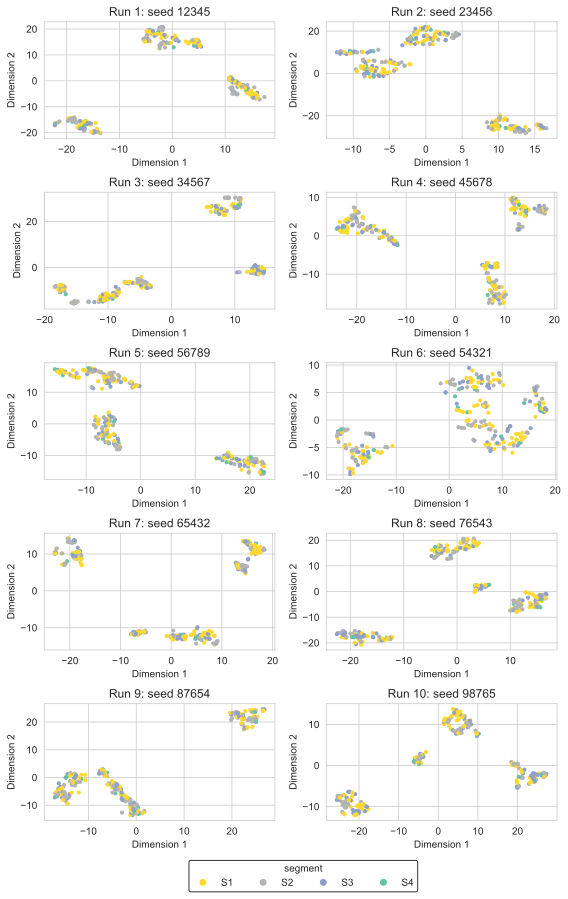

In [20]:
plot_embeddings(cheb_embeddings, 'cheb_scatterplots', True)

### Visualization of losses and accuracies

Finally, we take a look at the losses and accuracies in the training set, validation set and test set for the 10 runs for the best hyperparameter combination.

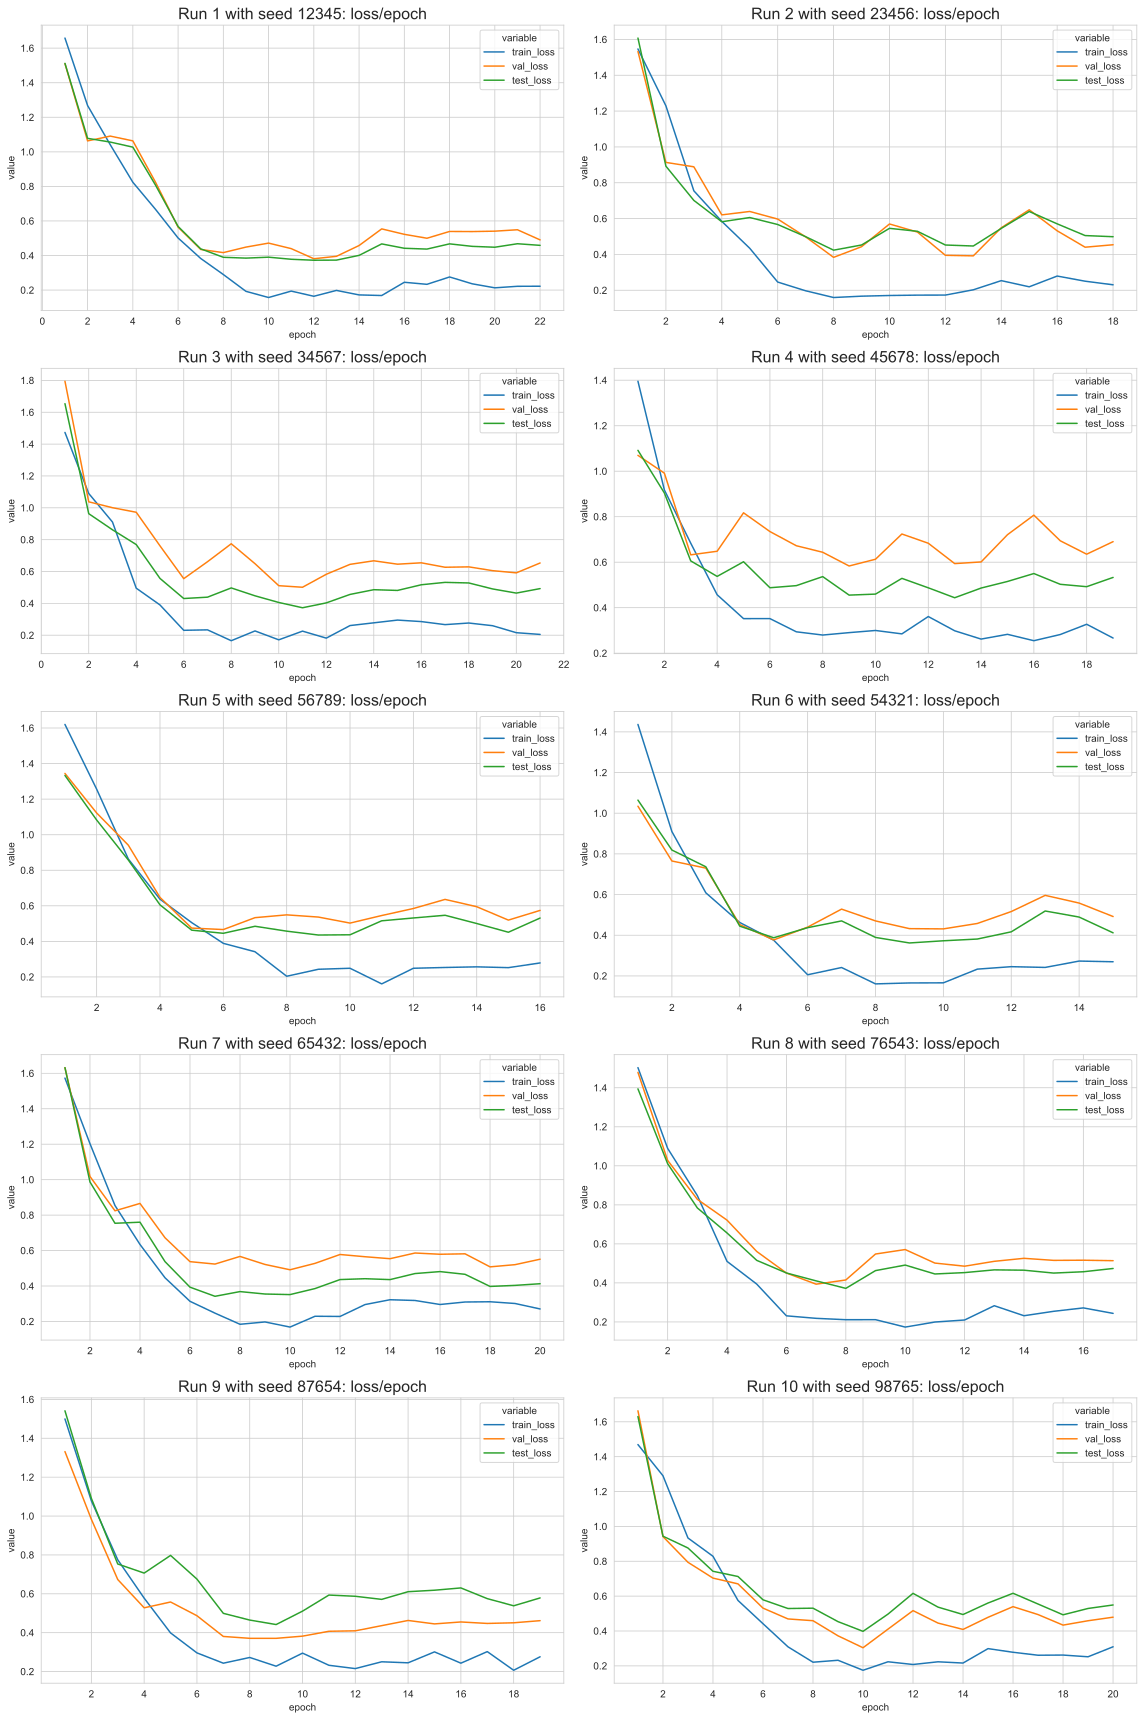

In [21]:
plot_losses_and_accuracies('loss', cheb_results, 307, 2.0, 'cheb_loss', True)

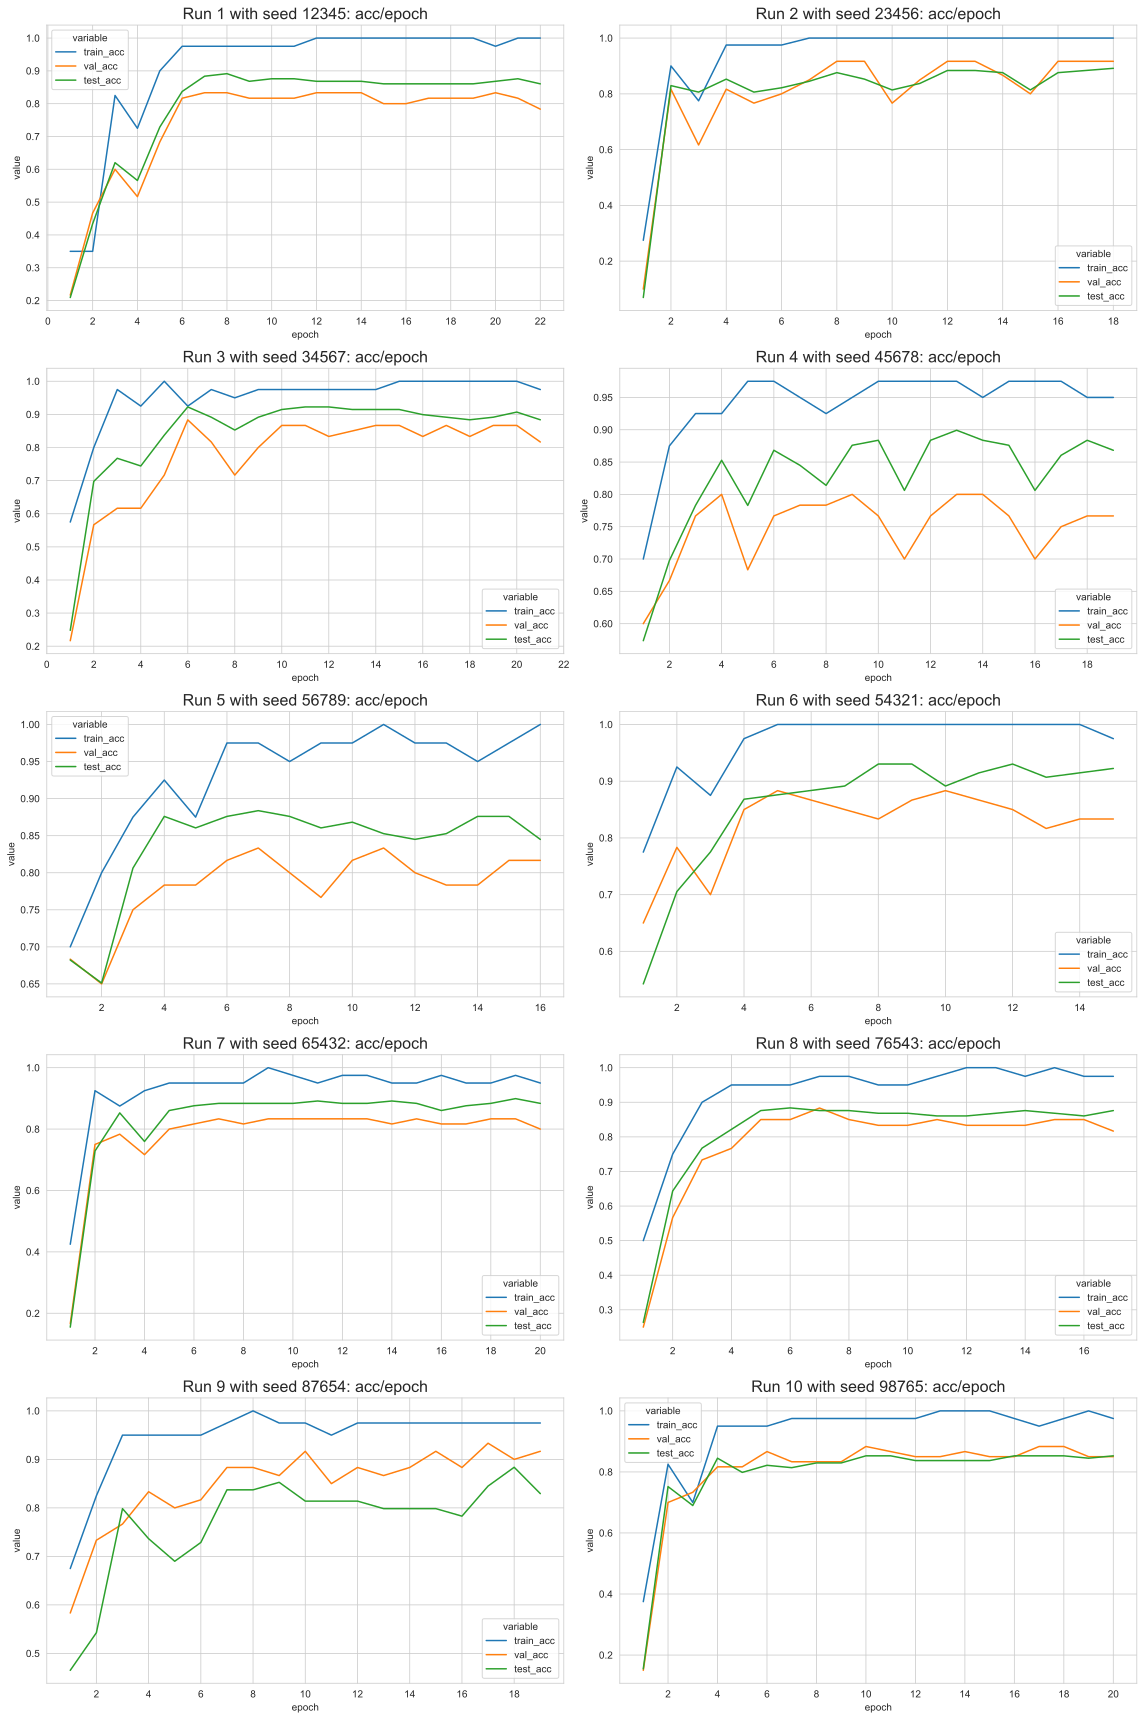

In [22]:
plot_losses_and_accuracies('acc', cheb_results, 307, 2.0, 'cheb_acc', True)